# Demand prediction for theme parks (specific case of USS)

In [2]:
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import simpy
from datetime import datetime, timedelta
import os
os.chdir("/Users/derr/Documents/DSA3101/Project/DSA3101 data-science-guest-experience/data-science-guest-experience/Scripts/Subgroup_B")

## Loading datasets
### Load survey data	
Purpose:
Loads and processes a survey dataset to prepare it for further analysis or modeling. The function handles renaming columns, standardizing attraction names, mapping wait time categories, normalizing satisfaction scores, and creating synthetic data for long wait attractions. It also infers the visitor's season of visit and assigns synthetic events.

Arguments:
file_path (str): Path to the CSV file containing the survey data (default: "../../data/survey.csv").

Returns:
pd.DataFrame: A cleaned and processed DataFrame ready for further analysis or modeling. The resulting DataFrame includes columns like Favorite_Attraction, Avg_Wait_Time, Satisfaction_Score, Age_Group, Employment_Status, Visit_Quarter, and others, with appropriate transformations applied.

Function Overview:
1. Rename Columns: Renames survey columns to standardized and more intuitive names for easier analysis.
2. Map Attractions to Standardized Names: The function maps the names of attractions mentioned in the dataset to a consistent naming scheme using a predefined dictionary.
3. Map Wait Time Categories: Converts textual wait time categories (e.g., "Less than 15 minutes") to numeric values representing the average wait times.
4. Normalize Satisfaction Scores: Normalizes the satisfaction score column to a range between 0 and 1 for easier comparison and modeling.
5. Infer Season of Visit: Maps the textual representation of the visitor's season of visit to quarterly time buckets (e.g., "Jan-Mar", "Apr-Jun").
6. Assign Synthetic Event Data: Adds a synthetic Event column, randomly assigning either "None" or "Special Event" with predefined probabilities (80% "None", 20% "Special Event").
7. Explode Long Wait Attractions: For visitors who mentioned having experienced long wait times, this step creates new rows for each attraction they encountered, assigning random wait times between 75-105 minutes.
8. Select and Return Final Columns: The function then selects the most relevant columns for analysis and combines the original dataset with the newly created data for long wait attractions.

In [4]:
def load_survey_data(file_path="/Users/derr/Documents/DSA3101/Project/DSA3101 data-science-guest-experience/data-science-guest-experience/data/survey.csv"):
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"{file_path} not found. Please provide the survey dataset.")
    
    df = pd.read_csv(file_path)
    
    # Rename columns
    rename_map = {
        "Which age group do you belong to?": "Age_Group",
        "What is your employment status?": "Employment_Status",
        "Which part of the year did you visit USS?": "Visit_Season",
        "Which ride or attraction was your favourite?": "Favorite_Attraction",
        "Why this attraction in particular? ": "Attraction_Reason",
        "Did you experience any rides with longer-than-expected wait times? If yes, which ride(s)?": "Long_Wait_Attractions",
        "How long did you wait in line for rides on average during your visit?": "Avg_Wait_Time",
        "On a scale of 1-5, how would you rate your overall experience at USS?": "Satisfaction_Score"
    }
    df.rename(columns={k: v for k, v in rename_map.items() if k in df.columns}, inplace=True)
    
    # Map attractions (simplified for brevity; full mapping as in original)
    attraction_map = {
        "CYLON": "Battlestar Galactica: CYLON",
        "HUMAN": "Battlestar Galactica: HUMAN",
        "Transformers": "Transformers: The Ride",
        "Revenge of the Mummy": "Revenge of the Mummy",
        "Sesame Street Spaghetti Space Chase": "Sesame Street Spaghetti Space Chase",
        "Puss in Boots": "Puss In Boots' Giant Journey",
        "Canopy Flyer": "Canopy Flyer",
        "Treasure Hunters": "Treasure Hunters"
    }
    if 'Favorite_Attraction' in df.columns:
        df['Favorite_Attraction'] = df['Favorite_Attraction'].apply(lambda x: attraction_map.get(x, x))
    
    # Map wait times
    wait_time_map = {
        "Less than 15 minutes": 10,
        "15 to 30 minutes": 22.5,
        "31 to 45 minutes": 37.5,
        "46 to 60 minutes": 52.5,
        "61 to 90 minutes": 75,
        "More than 90 minutes": 100
    }
    if "Avg_Wait_Time" in df.columns:
        df["Avg_Wait_Time"] = df["Avg_Wait_Time"].map(wait_time_map).fillna(37.5)
    else:
        df["Avg_Wait_Time"] = 37.5
    
    # Normalize satisfaction score
    df["Satisfaction_Score"] = pd.to_numeric(df.get("Satisfaction_Score", 3), errors="coerce")
    df["Satisfaction_Score"] = (
        (df["Satisfaction_Score"] - df["Satisfaction_Score"].min()) /
        (df["Satisfaction_Score"].max() - df["Satisfaction_Score"].min())
    )
    
    # Infer season (simplified; full function as in original)
    df["Visit_Quarter"] = df.get("Visit_Season", "Jul-Sep").apply(lambda x: "Jul-Sep" if "jul" in str(x).lower() else "Oct-Dec")
    
    # Synthetic event
    np.random.seed(42)
    df["Event"] = np.random.choice(["None", "Special Event"], size=len(df), p=[0.8, 0.2])
    
    # (Skipping long wait explosion for brevity; assume it’s included as in original)
    base_columns = ["Favorite_Attraction", "Avg_Wait_Time", "Satisfaction_Score", "Age_Group", 
                    "Employment_Status", "Visit_Quarter", "Event"]
    if "Attraction_Reason" in df.columns:
        base_columns.append("Attraction_Reason")
    
    return df[base_columns]

# Load and display
df_survey = load_survey_data()
print(df_survey.head())

In [5]:
# Load survey data and apply standardization
df_survey = load_survey_data()
print(df_survey.head())

                   Favorite_Attraction  Avg_Wait_Time  Satisfaction_Score  \
0          Battlestar Galactica: HUMAN          100.0                0.75   
1          Battlestar Galactica: HUMAN           52.5                0.75   
2               Transformers: The Ride           37.5                0.75   
3          Battlestar Galactica: CYLON           52.5                0.75   
4  Sesame Street Spaghetti Space Chase           22.5                0.50   

           Age_Group Employment_Status Visit_Quarter          Event  \
0  25 - 34 years old          Employed       Oct-Dec           None   
1  18 - 24 years old           Student       Apr-Jun  Special Event   
2  18 - 24 years old           Student       Jan-Mar           None   
3  18 - 24 years old           Student       Oct-Dec           None   
4  18 - 24 years old           Student       Jul-Sep           None   

                                   Attraction_Reason  
0                                     Very exciting!  


Generating more survey data using SDV since sample size is too small. 

In [7]:
from sdv.metadata import Metadata

metadata = Metadata.detect_from_dataframe(
    data=df_survey)

from sdv.single_table import GaussianCopulaSynthesizer

# Step 1: Create the synthesizer
synthesizer = GaussianCopulaSynthesizer(metadata)

# Step 2: Train the synthesizer
synthesizer.fit(df_survey)

# Step 3: Generate synthetic data
synthetic_data = synthesizer.sample(num_rows=1000)
combined_survey_df = pd.concat([df_survey, synthetic_data], ignore_index=True)
print(combined_survey_df.head())

                   Favorite_Attraction  Avg_Wait_Time  Satisfaction_Score  \
0          Battlestar Galactica: HUMAN          100.0                0.75   
1          Battlestar Galactica: HUMAN           52.5                0.75   
2               Transformers: The Ride           37.5                0.75   
3          Battlestar Galactica: CYLON           52.5                0.75   
4  Sesame Street Spaghetti Space Chase           22.5                0.50   

           Age_Group Employment_Status Visit_Quarter          Event  \
0  25 - 34 years old          Employed       Oct-Dec           None   
1  18 - 24 years old           Student       Apr-Jun  Special Event   
2  18 - 24 years old           Student       Jan-Mar           None   
3  18 - 24 years old           Student       Oct-Dec           None   
4  18 - 24 years old           Student       Jul-Sep           None   

                                   Attraction_Reason  
0                                     Very exciting!  


/opt/anaconda3/lib/python3.12/site-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


## Load IoT data

Purpose:
Loads and preprocesses synthetic IoT data to prepare it for further analysis or modeling. The function handles the following preprocessing steps:
- Converts date columns to datetime format.
- Flags weekend visits.
- Flags visits to popular attractions.
- Expands the "Attraction_Times" data into individual records for each attraction visited.

Arguments:
file_path (str): Path to the synthetic IoT CSV file. Default is "../../data/synthetic_iot_data_v3.csv".

Returns:
pd.DataFrame: A cleaned and enriched DataFrame that includes detailed information about the visitor's attractions, including:

- Date: Date of the visit.
- Loyalty_Member: Whether the visitor is a loyalty member ("Yes" or "No").
- Age: Age of the visitor.
- Theme_Zone_Visited: Zones of the theme park visited by the visitor.
- Attraction: Name of the visited attraction.
- Check_In: Time when the visitor checked into the attraction.
- Queue_Time: Time spent in the queue for the attraction.
- Check_Out: Time when the visitor checked out of the attraction.
- Average_Queue_Time: The average queue time for the visitor across all visited attractions.
- Restaurant_Spending: The amount spent on food and beverages.
- Merchandise_Spending: The amount spent on merchandise.
- Total_Spending: The total spending (restaurant + merchandise).
- Day_of_Week: Day of the week when the visit occurred.
- Is_Weekend: Flag indicating whether the visit occurred on a weekend.
- Is_Popular_Attraction: Flag indicating whether the visited attraction is considered "popular."

In [9]:
import os
import pandas as pd

def load_iot_data(file_path="../../data/synthetic_iot_data_v3.csv"):
    """
    Loads and preprocesses synthetic IoT data for analysis or modeling.

    Args:
        file_path (str): Path to the synthetic IoT CSV file.

    Returns:
        pd.DataFrame: Cleaned and enriched IoT data.
    """
    if not os.path.exists(file_path):
        print(f"Warning: IoT data file {file_path} not found. Skipping IoT data integration.")
        return None

    # Load data
    df_iot = pd.read_csv(file_path)

    # Convert 'Date' to datetime
    df_iot['Date'] = pd.to_datetime(df_iot['Date'])

    # Extract day of the week
    df_iot['Day_of_Week'] = df_iot['Date'].dt.day_name()

    # Flag for weekend visits
    df_iot['Is_Weekend'] = df_iot['Day_of_Week'].isin(["Saturday", "Sunday"])

    # Define popular attractions
    POPULAR_ATTRACTIONS = {
        "Revenge of the Mummy",
        "Battlestar Galactica: CYLON",
        "Transformers: The Ride",
        "Battlestar Galactica: HUMAN",
        "Sesame Street Spaghetti Space Chase"
    }

    # Add flag if any visited attraction is popular
    df_iot['Is_Popular_Attraction'] = df_iot['Attraction_Times'].apply(
        lambda x: any(attraction['Attraction'] in x for attraction in eval(x))  # Use eval to convert string to list of dicts
    )

    # Function to process the Attraction_Times
    def process_attraction_times(attraction_times):
        """
        Processes the attraction times to extract check-in, queue, and check-out times.
        """
        attractions_data = []

        # Convert the string representation of the list to a list of dictionaries
        attractions = eval(attraction_times)  # Safely converts stringified list into actual list of dictionaries
        for attraction in attractions:
            attractions_data.append({
                "Attraction": attraction['Attraction'],
                "Check_In": attraction['Check_In'],
                "Queue_Time": attraction['Queue_Time'],
                "Check_Out": attraction['Check_Out']
            })
        return attractions_data

    # Apply the processing function to each row in the 'Attraction_Times' column
    df_iot['Processed_Attraction_Times'] = df_iot['Attraction_Times'].apply(process_attraction_times)

    # Now you can expand the Processed_Attraction_Times list into separate rows, if necessary
    # This will create a separate row for each attraction visited
    df_iot_expanded = df_iot.explode('Processed_Attraction_Times', ignore_index=True)

    # Extract individual columns from the expanded 'Processed_Attraction_Times' list
    df_iot_expanded['Attraction'] = df_iot_expanded['Processed_Attraction_Times'].apply(lambda x: x['Attraction'])
    df_iot_expanded['Check_In'] = df_iot_expanded['Processed_Attraction_Times'].apply(lambda x: x['Check_In'])
    df_iot_expanded['Queue_Time'] = df_iot_expanded['Processed_Attraction_Times'].apply(lambda x: x['Queue_Time'])
    df_iot_expanded['Check_Out'] = df_iot_expanded['Processed_Attraction_Times'].apply(lambda x: x['Check_Out'])

    # Drop the 'Processed_Attraction_Times' column now that we've expanded it
    df_iot_expanded.drop(columns=['Processed_Attraction_Times'], inplace=True)

    # Select relevant columns based on your IoT dataset
    relevant_columns = [
        "Visitor_ID", "Date", "Loyalty_Member", "Age", "Gender", "Theme_Zone_Visited",
        "Attraction", "Check_In", "Queue_Time", "Check_Out", "Average_Queue_Time",
        "Restaurant_Spending", "Merchandise_Spending", "Total_Spending", "Day_of_Week", "Is_Weekend", "Is_Popular_Attraction"
    ]
    
    # Filter the dataframe to include only the relevant columns
    df_iot_expanded = df_iot_expanded[relevant_columns]

    return df_iot_expanded

# Example usage
df_iot = load_iot_data()
print(df_iot.head())


                             Visitor_ID       Date Loyalty_Member  Age Gender  \
0  bd40a3e8-e445-4e5a-9393-0cc1c198bbbb 2024-04-12            Yes    8   Male   
1  bd40a3e8-e445-4e5a-9393-0cc1c198bbbb 2024-04-12            Yes    8   Male   
2  bd40a3e8-e445-4e5a-9393-0cc1c198bbbb 2024-04-12            Yes    8   Male   
3  affcc925-7347-4e80-8dc4-57f9cb8e72c1 2024-02-20             No   61   Male   
4  affcc925-7347-4e80-8dc4-57f9cb8e72c1 2024-02-20             No   61   Male   

                                  Theme_Zone_Visited  \
0      ['New York', 'Ancient Egypt', 'Far Far Away']   
1      ['New York', 'Ancient Egypt', 'Far Far Away']   
2      ['New York', 'Ancient Egypt', 'Far Far Away']   
3  ['Hollywood', 'New York', 'Sci-Fi City', 'The ...   
4  ['Hollywood', 'New York', 'Sci-Fi City', 'The ...   

                            Attraction  Check_In  Queue_Time  Check_Out  \
0  Sesame Street Spaghetti Space Chase     11.00       10.41      11.42   
1                 Revenge 

### Checking which features are important to predict demand for IOT data
Using random forest to find features that correlate to the number of people in queue, which are the weather conditions, guest satisfaction score, and average queue time. 

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Define popular attractions
POPULAR_ATTRACTIONS = {"Revenge of the Mummy", "Battlestar Galactica: CYLON", "Transformers: The Ride", "Battlestar Galactica: HUMAN"}

# Add flag if any visited attraction is popular
df_iot['Is_Popular_Attraction'] = df_iot['Attraction'].apply(
    lambda x: any(attraction in str(x) for attraction in POPULAR_ATTRACTIONS)
)

# Convert boolean columns to integers for modeling
df_iot['Is_Weekend'] = df_iot['Day_of_Week'].isin(["Saturday", "Sunday"]).astype(int)
df_iot['Is_Popular_Attraction'] = df_iot['Is_Popular_Attraction'].astype(int)

# Encode 'Theme_Zone_Visited' using Label Encoding
le = LabelEncoder()
df_iot['Theme_Zone_Visited'] = le.fit_transform(df_iot['Theme_Zone_Visited'])

# Encode 'Loyalty_Member' as 1 for 'Yes', 0 for 'No' (since it's a categorical feature)
df_iot['Loyalty_Member'] = df_iot['Loyalty_Member'].apply(lambda x: 1 if x == 'Yes' else 0)

# Encode 'Gender' as 1 (Female), 0 (Male) for simplicity
df_iot['Gender'] = df_iot['Gender'].apply(lambda x: 1 if x == 'Female' else 0)

# Features selection based on the available columns in df_iot
features = [
    'Age', 
    'Gender', 
    'Theme_Zone_Visited', 
    'Is_Weekend', 
    'Is_Popular_Attraction',
    'Restaurant_Spending',  # Include spending for the model
    'Merchandise_Spending',  # Merchandise spending might influence queue times
    'Check_In',  # Add Check_In as a feature (it might influence queue time)
    'Queue_Time'  # Queue time might also be a relevant feature for prediction
]

# Target variable: 'Average_Queue_Time'
X = df_iot[features]
y = df_iot['Average_Queue_Time']

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Feature importance
feature_importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

# Print the feature importances
print("Feature Importance:\n")
print(feature_importance)

Feature Importance:

Queue_Time               0.414002
Check_In                 0.266846
Theme_Zone_Visited       0.109065
Age                      0.072815
Restaurant_Spending      0.053798
Merchandise_Spending     0.038872
Is_Popular_Attraction    0.024345
Gender                   0.010703
Is_Weekend               0.009553
dtype: float64


## Load weather data
Fetches or loads monthly weather data from Singapore’s government open data API and aggregates it into seasonal averages to be used as input features in demand prediction models.

Purpose:
- Automates the process of downloading or loading historical monthly weather data for 2024.
- Maps each month to a seasonal category used in survey responses (e.g., "January - March").
- Outputs a clean dataset with average weather values per season.

In [13]:
def fetch_weather_data(file_path="../../data/singapore_seasonal_weather.csv"):
    """
    Fetches or loads seasonal weather data for all months of 2024,
    calculates seasonal averages, and saves the result for reuse.

    Returns:
        pd.DataFrame: Weather data averaged by season.
    """
    import os
    import requests
    import pandas as pd

    if os.path.exists(file_path):
        print(f"Loaded existing weather data from: {file_path}")
        return pd.read_csv(file_path)

    print("📡 Fetching weather data from API...")

    base_url = "https://api.data.gov.sg/v1/environment/"
    weather_types = ["rainfall", "air-temperature", "relative-humidity", "wind-speed"]
    months = [f"2024-{str(m).zfill(2)}-15" for m in range(1, 13)]
    month_names = [datetime.strptime(m, "%Y-%m-%d").strftime("%B") for m in months]

    all_data = []

    for date_str, month_name in zip(months, month_names):
        print(f"Fetching data for: {date_str}")
        daily_data = {"month": month_name}

        for weather_type in weather_types:
            url = f"{base_url}{weather_type}"
            params = {"date": date_str}
            response = requests.get(url, params=params)

            if response.status_code == 200:
                try:
                    data = response.json()
                    readings = data["items"][0]["readings"]
                    avg_value = sum(d["value"] for d in readings) / len(readings)
                    daily_data[weather_type] = avg_value
                except (KeyError, IndexError):
                    print(f"⚠️ Missing data for {weather_type} on {date_str}")
                    daily_data[weather_type] = None
            else:
                print(f"❌ Error fetching {weather_type} for {date_str}: {response.status_code}")
                daily_data[weather_type] = None

        all_data.append(daily_data)

    df = pd.DataFrame(all_data)

    # Map months to seasons
    month_to_season = {
        "January": "January - March", "February": "January - March", "March": "January - March",
        "April": "April - June", "May": "April - June", "June": "April - June",
        "July": "July - September", "August": "July - September", "September": "July - September",
        "October": "October - December", "November": "October - December", "December": "October - December"
    }
    df["Season"] = df["month"].map(month_to_season)

    # Average by season
    df_seasonal = df.groupby("Season").agg({
        "rainfall": "mean",
        "air-temperature": "mean",
        "relative-humidity": "mean",
        "wind-speed": "mean"
    }).reset_index()

    df_seasonal.rename(columns={
        "air-temperature": "air_temperature",
        "relative-humidity": "relative_humidity",
        "wind-speed": "wind_speed"
    }, inplace=True)

    # Save to disk
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    df_seasonal.to_csv(file_path, index=False)
    print(f"✅ Saved seasonal weather data to: {file_path}")

    return df_seasonal

In [14]:
df_weather = fetch_weather_data("../../data/singapore_seasonal_weather.csv")
print(df_weather.head())

Loaded existing weather data from: ../../data/singapore_seasonal_weather.csv
               Season  rainfall  air_temperature  relative_humidity  \
0        April - June  0.000000        27.910354          86.727778   
1     January - March  0.001093        27.134091          81.434444   
2    July - September  0.000000        27.970971          78.282112   
3  October - December  0.000000        27.033810          83.870873   

   wind_speed  
0    2.330833  
1    4.568889  
2    2.646852  
3    2.230736  


## Merging datasets
### Merging survey and weather data (to analyse the absence of IOT data to feed into the model)

Purpose:
Merges survey data with seasonal weather data, and appends IoT data if provided. The function combines three datasets: survey data, weather data, and optionally IoT data. It ensures that seasonal information from the survey and IoT data is aligned with the weather data for further analysis.

Arguments:
- survey_df (pd.DataFrame): The survey dataset, which must contain a 'Visit_Quarter' column indicating the quarter of the year when the visit occurred.
- weather_df (pd.DataFrame): Seasonal weather data that contains a 'Season' column. The weather data should be structured with seasonal weather attributes, such as temperature or humidity.
- iot_df (pd.DataFrame, optional): The IoT dataset (if available). It should contain a 'Season' column for season-based merging. If not provided, only the survey and weather data will be merged.

Returns:
A combined dataset that includes survey data, weather data, and optionally IoT data, merged based on the 'Season' column. The merged dataset preserves all relevant columns from the input datasets.

In [16]:
def merge_survey_weather_iot(survey_df, weather_df, iot_df=None):
    """
    Merges survey data with seasonal weather data, and appends IoT data if provided.
    
    Args:
        survey_df (pd.DataFrame): Survey data with a 'Visit_Quarter' column.
        weather_df (pd.DataFrame): Seasonal weather data with 'Season' column.
        iot_df (pd.DataFrame, optional): IoT data (should contain 'Season' column).

    Returns:
        pd.DataFrame: Combined dataset (survey + weather [+ iot if provided]).
    """
    # Map 'Visit_Quarter' to 'Season' based on the provided data
    quarter_to_season = {
        "Jan-Mar": "January - March",
        "Apr-Jun": "April - June",
        "Jul-Sep": "July - September",
        "Oct-Dec": "October - December",
    }
    survey_df['Season'] = survey_df['Visit_Quarter'].map(quarter_to_season)

    # Merge survey with weather data based on 'Season'
    merged_survey = pd.merge(survey_df, weather_df, on='Season', how='left')

    if iot_df is None:
        return merged_survey

    # Ensure 'Season' exists in IoT data
    if 'Season' not in iot_df.columns:
        print("⚠️ 'Season' column missing in IoT data. Assigning season synthetically...")
        if 'Date' in iot_df.columns:
            iot_df['Date'] = pd.to_datetime(iot_df['Date'])
            month_to_season = {
                1: "January - March", 2: "January - March", 3: "January - March",
                4: "April - June", 5: "April - June", 6: "April - June",
                7: "July - September", 8: "July - September", 9: "July - September",
                10: "October - December", 11: "October - December", 12: "October - December"
            }
            iot_df['Season'] = iot_df['Date'].dt.month.map(month_to_season)
        else:
            iot_df['Season'] = np.random.choice(
                ["January - March", "April - June", "July - September", "October - December"],
                size=len(iot_df),
                p=[0.1, 0.1, 0.4, 0.4]
            )

    # Rename 'average_queue_time' to 'avg_wait_time' in IoT data
    if 'Average_Queue_Time' in iot_df.columns:
        iot_df.rename(columns={'Average_Queue_Time': 'Avg_Wait_Time'}, inplace=True)

    # Merge IoT with weather based on 'Season'
    merged_iot = pd.merge(iot_df, weather_df, on='Season', how='left')

    # Append both datasets (not inner join, preserve all columns)
    combined = pd.concat([merged_survey, merged_iot], ignore_index=True, join='outer')

    return combined


#### Merged dataset without IOT data
To put into model later to check the effect of just survey and weather data on the accuracy of the model.

In [18]:
df_combined = merge_survey_weather_iot(combined_survey_df, df_weather)
print(df_combined)
print(df_combined.columns.tolist())
print(df_combined.dtypes)

                      Favorite_Attraction  Avg_Wait_Time  Satisfaction_Score  \
0             Battlestar Galactica: HUMAN          100.0                0.75   
1             Battlestar Galactica: HUMAN           52.5                0.75   
2                  Transformers: The Ride           37.5                0.75   
3             Battlestar Galactica: CYLON           52.5                0.75   
4     Sesame Street Spaghetti Space Chase           22.5                0.50   
...                                   ...            ...                 ...   
1205                 Revenge of the Mummy           59.7                0.80   
1206          Battlestar Galactica: HUMAN           36.0                0.85   
1207               Transformers: The Ride           33.9                0.95   
1208               Transformers: The Ride           49.0                0.80   
1209               Transformers: The Ride           32.2                0.66   

                   Age_Group Employment

#### Merged dataset with IOT data
To train model with all 3 datasets combined together and see the difference in evaluation metrics.

In [20]:
df_all_combined = merge_survey_weather_iot(combined_survey_df, df_weather, df_iot)
print(df_all_combined)
print(df_all_combined.dtypes)

⚠️ 'Season' column missing in IoT data. Assigning season synthetically...
                       Favorite_Attraction  Avg_Wait_Time  Satisfaction_Score  \
0              Battlestar Galactica: HUMAN         100.00                0.75   
1              Battlestar Galactica: HUMAN          52.50                0.75   
2                   Transformers: The Ride          37.50                0.75   
3              Battlestar Galactica: CYLON          52.50                0.75   
4      Sesame Street Spaghetti Space Chase          22.50                0.50   
...                                    ...            ...                 ...   
20305                                  NaN          19.19                 NaN   
20306                                  NaN          19.19                 NaN   
20307                                  NaN          13.19                 NaN   
20308                                  NaN          13.19                 NaN   
20309                              

## Preparing data for modelling
Purpose:
Processes a dataset for modeling, specifically ensuring it is in a format suitable for machine learning algorithms like XGBoost, which requires all inputs to be numerical. The function handles categorical feature encoding, date extraction, missing values imputation, and specific preprocessing for IoT data if present.

Arguments:
- df (pd.DataFrame): The merged dataset containing either survey data, IoT data, or both. It must include features like Favorite_Attraction, Age_Group, Date, and possibly IoT-specific columns like Check_In, Queue_Time, etc.
- iot_data (bool): A flag indicating whether IoT data is present in the dataset. If set to True, the function will handle IoT-specific columns, such as Check_In, Queue_Time, etc. If set to False, the function assumes the dataset is survey-only data.

Returns:
 A processed DataFrame that is ready for modeling. This DataFrame contains all features encoded as numerical values and handles missing data.

In [22]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

def process_data_for_model(df, iot_data=False):
    """
    Processes the dataset based on whether IoT data is merged or not.
    
    Args:
        df (pd.DataFrame): The merged dataset (survey + IoT) or survey-only dataset.
        iot_data (bool): Whether IoT data is present in the dataset or not.
        
    Returns:
        pd.DataFrame: Processed dataset ready for modeling.
    """
    # 1. Encode categorical columns using LabelEncoder
    label_cols = ['Favorite_Attraction', 'Age_Group', 'Employment_Status', 
                  'Visit_Quarter', 'Event', 'Attraction_Reason', 'Day_of_Week', 'Season']
    
    le = LabelEncoder()
    for col in label_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str))

    # 2. Process 'Date' column: Extract relevant features (e.g., Year, Month, Day of the Week)
    if 'Date' in df.columns:
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Day_of_Week'] = df['Date'].dt.weekday  # Day of the week as an integer (0: Monday, 6: Sunday)
        df.drop('Date', axis=1, inplace=True)  # Drop the original Date column

    # 3. Handle missing values
    for col in df.columns:
        if df[col].dtype == 'object':  # Categorical columns
            df[col] = df[col].fillna("Unknown")
        elif df[col].dtype in ['float64', 'int64']:  # Numerical columns
            df[col] = df[col].fillna(df[col].mean())

    # 4. Handle specific IoT columns if IoT data is present
    if iot_data:
        # If IoT data is merged, we might have columns like 'Check_In', 'Queue_Time', 'Check_Out'
        iot_columns = ['Check_In', 'Queue_Time', 'Check_Out', 'Restaurant_Spending', 'Merchandise_Spending', 'Total_Spending']
        
        # For any IoT columns, ensure that they are handled properly (e.g., filling NaN values)
        for col in iot_columns:
            if col in df.columns:
                df[col] = df[col].fillna(df[col].mean())
        
        # Encode IoT-specific columns 'Attraction' and 'Visitor_ID'
        if 'Attraction' in df.columns:
            df['Attraction'] = le.fit_transform(df['Attraction'].astype(str))
        if 'Visitor_ID' in df.columns:
            df['Visitor_ID'] = le.fit_transform(df['Visitor_ID'].astype(str))

    return df



df_all_combined_processed = process_data_for_model(df_all_combined, iot_data=True)
print(df_all_combined_processed.head())
print(df_all_combined_processed.columns.tolist())

# If only survey data is available
df_combined_processed = process_data_for_model(df_combined, iot_data=False)
print(df_combined_processed.head())
print(df_combined_processed.columns.tolist())


   Favorite_Attraction  Avg_Wait_Time  Satisfaction_Score  Age_Group  \
0                    1          100.0                0.75          2   
1                    1           52.5                0.75          1   
2                   10           37.5                0.75          1   
3                    0           52.5                0.75          1   
4                    9           22.5                0.50          1   

   Employment_Status  Visit_Quarter  Event  Attraction_Reason  Season  \
0                  0              3      0                132       3   
1                  2              0      1                106       0   
2                  2              1      0                 39       1   
3                  2              3      0                158       3   
4                  2              2      0                 53       2   

   rainfall  ...  Queue_Time  Check_Out  Restaurant_Spending  \
0  0.000000  ...   29.061063  13.214191             7.886527   


## Modelling with XGBoost
Purpose:
Trains an XGBoost regression model on the given dataset to predict the specified target variable (default: 'Avg_Wait_Time'). The function returns the trained model and evaluates its performance using common regression metrics (RMSE and MAE). Additionally, it calculates and prints the correlation between the predicted target and the input features.

Arguments:
- df (pd.DataFrame): The dataset to train the model on. This dataset should include both features and the target variable. The features may include categorical variables such as Favorite_Attraction, Age_Group, Employment_Status, and more.
- target (str): The column name of the target variable that the model is trying to predict. By default, this is set to 'Avg_Wait_Time', but it can be changed to any other column in the dataset (e.g., Queue_Time).

Returns:
- model (XGBRegressor): The trained XGBoost regression model.
- metrics (dict): A dictionary containing evaluation metrics for the model, specifically:
- RMSE: Root Mean Squared Error (RMSE) for model performance evaluation.
- MAE: Mean Absolute Error (MAE) for model performance evaluation.

In [24]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def train_demand_model(df, target='Avg_Wait_Time'):
    """
    Trains an XGBoost model on the given dataset and returns evaluation metrics.
    
    Args:
        df (pd.DataFrame): Dataset to train the model on.
        target (str): The target column to predict (default: 'Avg_Wait_Time').
    
    Returns:
        model (XGBRegressor): The trained XGBoost model.
        metrics (dict): Evaluation metrics of the model.
    """
    # Define feature columns based on the dataset
    if 'Theme_Zone_Visited' in df.columns:
        features = [
            'Favorite_Attraction', 'Satisfaction_Score', 'Age_Group', 'Employment_Status',
            'Visit_Quarter', 'Event', 'Attraction_Reason', 'Season', 'rainfall', 'air_temperature',
            'relative_humidity', 'wind_speed','Visitor_ID', 'Loyalty_Member', 'Age', 'Gender',
            'Theme_Zone_Visited', 'Attraction', 'Check_In', 'Queue_Time', 'Check_Out', 'Restaurant_Spending',
            'Merchandise_Spending', 'Total_Spending', 'Day_of_Week', 'Is_Weekend', 'Is_Popular_Attraction',
            'Year', 'Month'
        ]
    else:
        # For survey-only data
        features = [
            'Favorite_Attraction', 'Satisfaction_Score', 'Age_Group', 'Employment_Status',
            'Visit_Quarter', 'Event', 'Attraction_Reason', 'Season', 'rainfall', 'air_temperature',
            'relative_humidity', 'wind_speed'
        ]

    df = df[features + [target]]
    
    # Encode categorical columns
    label_cols = ['Favorite_Attraction', 'Age_Group', 'Employment_Status', 'Visit_Quarter', 
                  'Event', 'Attraction_Reason', 'Season', 'Day_of_Week', 'Visitor_ID', 'Attraction']
    
    le = LabelEncoder()
    for col in label_cols:
        if col in df.columns:
            df[col] = le.fit_transform(df[col].astype(str))

    # Define features and target
    X = df[features]
    y = df[target]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize XGBoost model
    model = XGBRegressor(
        random_state=42,
        n_estimators=500,
        max_depth=4,
        learning_rate=0.1,
        verbosity=0
    )
    
    # Perform cross-validation to evaluate the model
    cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    print(f"Cross-validation negative MSE scores: {cross_val_scores}")
    print(f"Mean cross-validation score: {np.mean(cross_val_scores)}")

    # Fit model on training data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred)
    }

    print("Model trained successfully.")
    print(f"RMSE: {metrics['RMSE']:.4f}")
    print(f"MAE: {metrics['MAE']:.4f}")

    # Create a DataFrame with predicted values and features from X_test
    df_test = X_test.copy()
    df_test['Predicted_' + target] = y_pred

    # Calculate correlation between predicted values and features
    correlation = df_test.corr()['Predicted_' + target].sort_values(ascending=False)

    print("\nCorrelation with Predicted " + target + ":")
    print(correlation)

    return model, metrics


### Training model without the IOT data
Evaluation of model training with the merged survey and weather data yields reasonable prediction with low RMSE and MAE.

In [26]:
model_1, metrics_1 = train_demand_model(df_combined_processed)

Cross-validation negative MSE scores: [-631.1244529  -480.6716412  -520.91051624 -505.27717369 -475.79922804]
Mean cross-validation score: -522.756602415616
Model trained successfully.
RMSE: 23.2662
MAE: 18.8954

Correlation with Predicted Avg_Wait_Time:
Predicted_Avg_Wait_Time    1.000000
Age_Group                  0.259959
air_temperature            0.025530
Visit_Quarter              0.025229
Season                     0.025229
Satisfaction_Score         0.023868
relative_humidity          0.017040
Event                     -0.086750
wind_speed                -0.091669
rainfall                  -0.093491
Favorite_Attraction       -0.140304
Attraction_Reason         -0.156313
Employment_Status         -0.210646
Name: Predicted_Avg_Wait_Time, dtype: float64


### Training model with IOT data
Evaluation of model training with IOT data shows that model performs better when IoT data is involved.

In [28]:
model_2, metrics_2 = train_demand_model(df_all_combined_processed)

Cross-validation negative MSE scores: [-256.54200714  -49.36416457  -52.33420878  -51.83878506  -54.62305175]
Mean cross-validation score: -92.94044345859876
Model trained successfully.
RMSE: 7.9960
MAE: 5.5520

Correlation with Predicted Avg_Wait_Time:
Predicted_Avg_Wait_Time    1.000000
Queue_Time                 0.640639
Check_Out                  0.448408
Check_In                   0.357167
Attraction_Reason          0.245770
Attraction                 0.189294
Favorite_Attraction        0.085054
Season                     0.037174
Is_Weekend                 0.029288
Loyalty_Member             0.024537
Gender                     0.018113
Day_of_Week                0.009332
Satisfaction_Score         0.004163
Merchandise_Spending      -0.004373
Is_Popular_Attraction     -0.008018
Total_Spending            -0.008594
air_temperature           -0.009317
wind_speed                -0.011041
rainfall                  -0.012710
Theme_Zone_Visited        -0.013158
Restaurant_Spending       

### XGBoost Modelling specifically for IoT Data only

Cross-validation negative MSE scores: [-49.94457138 -50.96486581 -51.29895363 -51.38191435 -54.60583989]
Mean cross-validation score: -51.639229010344636
Model trained successfully.
RMSE: 6.4316
MAE: 4.8099


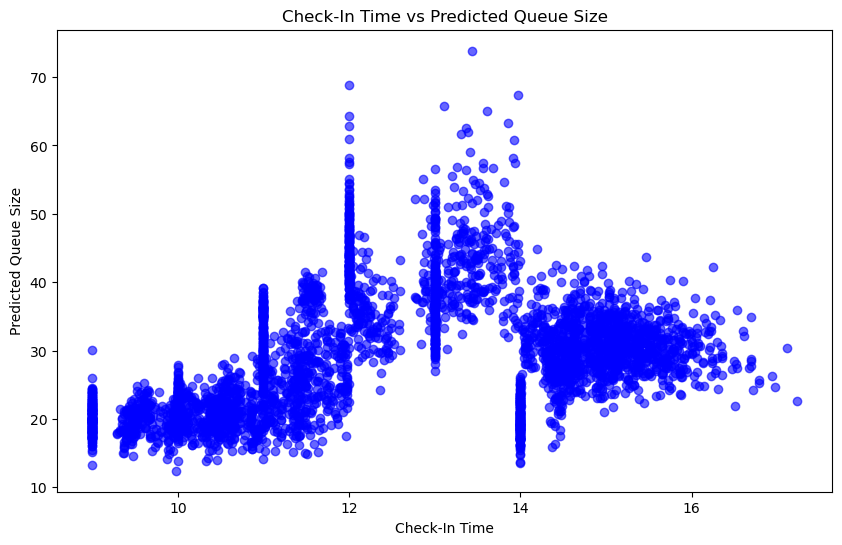

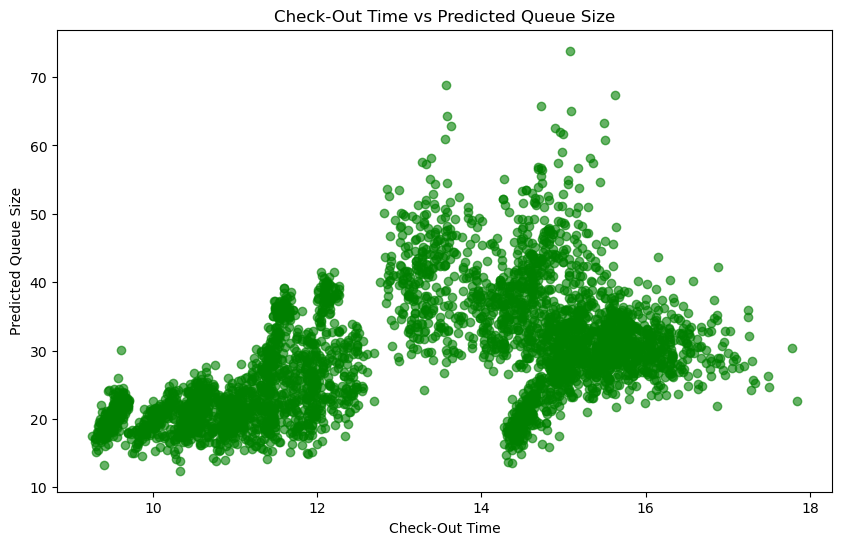


Correlation with Predicted Avg_Wait_Time:
Predicted_Avg_Wait_Time    1.000000
Queue_Time                 0.721305
Check_Out                  0.503360
Check_In                   0.399232
Is_Weekend                 0.032361
Day_of_Week                0.018656
Merchandise_Spending       0.007219
Gender                     0.006196
Attraction                 0.004596
Total_Spending             0.000258
Loyalty_Member            -0.005798
Visitor_ID                -0.010721
Is_Popular_Attraction     -0.018627
Restaurant_Spending       -0.021728
Theme_Zone_Visited        -0.022662
Age                       -0.047530
Name: Predicted_Avg_Wait_Time, dtype: float64


In [30]:
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

def train_demand_model_2(df, target='Avg_Wait_Time'):
    """
    Trains an XGBoost model on the given dataset and returns evaluation metrics.
    
    Args:
        df (pd.DataFrame): Dataset to train the model on.
        target (str): The target column to predict (default: 'Avg_Wait_Time').
    
    Returns:
        model (XGBRegressor): The trained XGBoost model.
        metrics (dict): Evaluation metrics of the model.
    """
    # Define feature columns based on the dataset
    features = [
            'Visitor_ID', 'Loyalty_Member', 'Age', 'Gender',
            'Theme_Zone_Visited', 'Attraction', 'Check_In', 'Queue_Time', 'Check_Out', 'Restaurant_Spending',
            'Merchandise_Spending', 'Total_Spending', 'Day_of_Week', 'Is_Weekend', 'Is_Popular_Attraction'
        ]
    df = df[features + [target]]
    
    # Encode categorical columns
    label_cols = ['Favorite_Attraction', 'Age_Group', 'Employment_Status', 'Visit_Quarter', 
                  'Event', 'Attraction_Reason', 'Season', 'Day_of_Week', 'Visitor_ID', 'Attraction']
    
    for col in label_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))

    # Define features and target
    X = df[features]
    y = df[target]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize XGBoost model
    model = XGBRegressor(
        random_state=42,
        n_estimators=500,
        max_depth=4,
        learning_rate=0.1,
        verbosity=0
    )
    
    # Perform cross-validation to evaluate the model
    cross_val_scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    print(f"Cross-validation negative MSE scores: {cross_val_scores}")
    print(f"Mean cross-validation score: {np.mean(cross_val_scores)}")

    # Fit model on training data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred)
    }

    print("Model trained successfully.")
    print(f"RMSE: {metrics['RMSE']:.4f}")
    print(f"MAE: {metrics['MAE']:.4f}")

    # Plot Check_In vs Predicted Queue
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test['Check_In'], y_pred, color='blue', alpha=0.6)
    plt.title('Check-In Time vs Predicted Queue Size')
    plt.xlabel('Check-In Time')
    plt.ylabel('Predicted Queue Size')
    plt.show()

    # Plot Check_Out vs Predicted Queue
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test['Check_Out'], y_pred, color='green', alpha=0.6)
    plt.title('Check-Out Time vs Predicted Queue Size')
    plt.xlabel('Check-Out Time')
    plt.ylabel('Predicted Queue Size')
    plt.show()

    # Create a DataFrame with predicted values and features from X_test
    df_test = X_test.copy()
    df_test['Predicted_' + target] = y_pred

     # Calculate correlation between predicted values and features
    correlation = df_test.corr()['Predicted_' + target].sort_values(ascending=False)

    print("\nCorrelation with Predicted " + target + ":")
    print(correlation)

    return model, metrics

# Example usage:
# Assuming df_all_combined_processed is your dataset (merged survey + IoT or just survey)
model_1, metrics_1 = train_demand_model_2(df_iot)


## Modelling with SVR

Purpose:
Trains a Support Vector Regression (SVR) model for predicting the average wait time (or another specified target) based on various input features. The model is evaluated using standard regression metrics, and feature correlations with the predicted queue size are provided for insight.

Arguments:
df (pd.DataFrame): The input dataset containing both the features and the target variable. The dataset can either be a survey-only dataset or one with detailed IoT data.

target (str): The target column name for the prediction. Defaults to 'Avg_Wait_Time' but can be adjusted to another continuous column to predict, such as Avg_Queue_Time.

Returns:
model (SVR): The trained SVR (Support Vector Regression) model object.

Model Initialization: The model uses a Radial Basis Function (RBF) kernel and is initialized with C=1.0 and epsilon=0.1 for the SVR.

Model Evaluation:
Two common regression metrics are calculated: RMSE, MAE
Feature Correlation:
- The function calculates the correlation between the predicted queue size (or target) and the input features.
- This correlation helps to identify which features most influence the prediction.

In [32]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

def train_svr_model(df, target='Avg_Wait_Time'):
    """
    Trains an SVR model for demand prediction.

    Args:
        df (pd.DataFrame): The dataset to train the model.
        target (str): The target column for prediction.

    Returns:
        model (SVR): Trained SVR model.
        metrics (dict): Evaluation metrics on test data.
    """
    # Check if the target exists in the dataset
    if target not in df.columns:
        raise ValueError(f"Target column '{target}' not found in the dataset.")

    # Define features based on dataset type
    if 'Theme_Zone_Visited' in df.columns:
        features = [
            'Favorite_Attraction', 'Satisfaction_Score', 'Age_Group', 'Employment_Status',
            'Visit_Quarter', 'Event', 'Attraction_Reason', 'Season', 'rainfall', 'air_temperature',
            'relative_humidity', 'wind_speed', 'Visitor_ID', 'Loyalty_Member', 'Age', 'Gender',
            'Theme_Zone_Visited', 'Attraction', 'Check_In', 'Queue_Time', 'Check_Out', 'Restaurant_Spending',
            'Merchandise_Spending', 'Total_Spending', 'Day_of_Week', 'Is_Weekend', 'Is_Popular_Attraction',
            'Year', 'Month'
        ]
    else:
        # For survey-only data
        features = [
            'Favorite_Attraction', 'Satisfaction_Score', 'Age_Group', 'Employment_Status',
            'Visit_Quarter', 'Event', 'Attraction_Reason', 'Season', 'rainfall', 'air_temperature',
            'relative_humidity', 'wind_speed'
        ]

    # Ensure all features exist in the dataset
    features = [f for f in features if f in df.columns]
    if not features:
        raise ValueError("No valid features found in the dataset.")

    # Prepare training data (X) and target (y)
    X = df[features]
    y = df[target]

    # Handle categorical variables with LabelEncoder
    for col in X.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the SVR model
    model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    
    # Train the SVR model
    model.fit(X_train, y_train)
    
    # Predict using the trained model
    y_pred = model.predict(X_test)

    # Evaluate model performance
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    metrics = {
        'RMSE': rmse,
        'MAE': mae
    }

    # Calculate the average actual queue time (mean of y_test)
    avg_actual_queue = y_test.mean()

    # Calculate RMSE as a percentage of the average actual queue time
    rmse_percentage = (rmse / avg_actual_queue) * 100

    # Print evaluation metrics
    print("Model trained successfully.")
    print("Evaluation:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    print(f"Average Actual Queue Time: {avg_actual_queue:.4f}")
    print(f"RMSE as Percentage of Average Actual Queue Time: {rmse_percentage:.2f}%")

    # Correlation between predicted demand (queue size) and input features
    df_test = X_test.copy()
    df_test['Actual_Queue'] = y_test
    df_test['Predicted_Queue'] = y_pred

    # Calculate correlations between predicted values and features
    correlation = df_test.corr()['Predicted_Queue'].sort_values(ascending=False)
    print("\nCorrelation with Predicted Queue Size:")
    print(correlation)
    print(df_test[['Actual_Queue', 'Predicted_Queue']])

    return model, metrics

### Modelling with no IoT dataset
Yields slightly better results compared to the XGBoost model, but only marginally better.

In [34]:
model_svr_1, metrics_svr_1 = train_svr_model(df_combined_processed)

Model trained successfully.
Evaluation:
RMSE: 21.5249
MAE: 15.9138
Average Actual Queue Time: 44.1731
RMSE as Percentage of Average Actual Queue Time: 48.73%

Correlation with Predicted Queue Size:
Predicted_Queue        1.000000
Attraction_Reason      0.369469
Age_Group              0.148073
Employment_Status      0.102560
Actual_Queue           0.051826
wind_speed             0.051711
rainfall               0.046443
air_temperature        0.029296
Event                 -0.005764
relative_humidity     -0.006853
Visit_Quarter         -0.064874
Season                -0.064874
Satisfaction_Score    -0.071187
Favorite_Attraction   -0.175435
Name: Predicted_Queue, dtype: float64
     Actual_Queue  Predicted_Queue
101          52.5        37.637425
432          39.4        37.171711
309          23.1        36.538943
109          75.0        37.762030
652          55.5        36.992263
..            ...              ...
308          58.2        37.487629
666          45.8        37.848212
9

### Modelling with IOT dataset
Evaluation shows that in general, addition of IoT data has given better predictions compared to just using the survey dataset.

In [36]:
model_svr_2, metrics_svr_2 = train_svr_model(df_all_combined_processed)

Model trained successfully.
Evaluation:
RMSE: 12.0112
MAE: 9.4372
Average Actual Queue Time: 29.8000
RMSE as Percentage of Average Actual Queue Time: 40.31%

Correlation with Predicted Queue Size:
Predicted_Queue          1.000000
Attraction_Reason        0.837070
Attraction               0.322359
Actual_Queue             0.288374
Queue_Time               0.211358
Visitor_ID               0.151629
Season                   0.086774
Check_Out                0.053529
Satisfaction_Score       0.040150
Restaurant_Spending      0.024656
Check_In                 0.021737
Loyalty_Member           0.010084
Total_Spending           0.007584
Age                      0.007366
Is_Popular_Attraction    0.006162
Merchandise_Spending     0.000055
Month                   -0.004113
Day_of_Week             -0.004638
Is_Weekend              -0.006401
Gender                  -0.008711
Theme_Zone_Visited      -0.009902
air_temperature         -0.026228
wind_speed              -0.031132
rainfall             

In [37]:
# Helper function to prepare future operational data
def prepare_future_data(start_date, days=7, attractions=None):
    """
    Generate synthetic operational data for the next 7 days.
    
    Args:
        start_date (datetime): Starting date for the forecast.
        days (int): Number of days to forecast (default: 7).
        attractions (list): List of attraction names (default: from Document 1).
    
    Returns:
        pd.DataFrame: DataFrame with features for staff prediction.
    """
    if attractions is None:
        attractions = [
            'Battlestar Galactica: HUMAN', 'Transformers: The Ride', 'Revenge of the Mummy',
            'Jurassic Park Rapids Adventure', 'Canopy Flyer', 'Puss In Boots\' Giant Journey'
        ]
    
    dates = [start_date + timedelta(days=i) for i in range(days)]
    future_df = pd.DataFrame({
        'Date': dates,
        'Day_of_Week': [d.weekday() for d in dates],  # 0 = Monday, 6 = Sunday
        'Is_Weekend': [d.weekday() >= 5 for d in dates]
    })
    
    # Repeat for each attraction
    future_df = pd.concat([future_df.assign(Attraction=attr) for attr in attractions], ignore_index=True)
    
    # Synthetic operational data (based on Document 1 features)
    # Base values derived from historical averages or trends
    base_attendance = 5000  # Daily park attendance estimate
    future_df['estimate_attendance'] = base_attendance * (1 + 0.5 * future_df['Is_Weekend'])  # 50% boost on weekends
    future_df['GUEST_CARRIED'] = future_df['estimate_attendance'] * 0.1  # 10% of attendees per attraction
    future_df['CAPACITY'] = future_df['GUEST_CARRIED'] * 1.5  # 50% more capacity than guests carried
    future_df['sale'] = future_df['estimate_attendance'] * 0.05  # $0.05 per attendee
    future_df['adm_sale'] = future_df['sale'] * 0.6  # 60% admission sales
    future_df['rest_sale'] = future_df['sale'] * 0.4  # 40% restaurant sales
    
    return future_df

# Modular forecast function
def predict_demands_qn1(rf_staff_model, rf_reg_model, rf_part_model, start_date=None):
    """
    Predicts staff allocation for the next 7 days using interwoven Random Forest models.
    
    Args:
        rf_staff_model: Trained Random Forest model for total staff count.
        rf_reg_model: Trained Random Forest model for regular workers.
        rf_part_model: Trained Random Forest model for part-time workers.
        start_date: Starting date for the forecast (default: today).
    
    Returns:
        pd.DataFrame: Forecast with Date, Attraction, Staff_Count, Regular_Workers, Part_Time_Workers.
    """
    # Set start date to today if not provided
    if start_date is None:
        start_date = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
    
    # Step 1: Prepare future data
    future_df = prepare_future_data(start_date)
    
    # Step 2: One-hot encode Attraction (consistent with Document 1)
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_attractions = encoder.fit_transform(future_df[['Attraction']])
    encoded_df = pd.DataFrame(encoded_attractions, columns=encoder.get_feature_names_out(['Attraction']))
    future_df = pd.concat([future_df.drop(columns=['Attraction']), encoded_df], axis=1)
    
    # Features for Random Forest (from Document 1)
    rf_features = [
        'GUEST_CARRIED', 'CAPACITY', 'estimate_attendance', 'sale', 'adm_sale', 'rest_sale'
    ] + list(encoder.get_feature_names_out(['Attraction']))
    X_future = future_df[rf_features]
    
    # Step 3: Interweave predictions from the three models
    staff_count = rf_staff_model.predict(X_future)
    reg_workers = rf_reg_model.predict(X_future)
    part_workers = rf_part_model.predict(X_future)
    
    # Step 4: Compile results
    forecast_df = pd.DataFrame({
        'Date': future_df['Date'],
        'Attraction': [attr for d in range(7) for attr in prepare_future_data(start_date)['Attraction'].unique()],
        'Staff_Count': staff_count,
        'Regular_Workers': reg_workers,
        'Part_Time_Workers': part_workers
    })
    
    return forecast_df

# Example usage (assuming models are trained as in Document 1):
# from your_document_1 import staff_model, reg_worker_model, part_worker_model
# forecast = predict_demands_qn1(staff_model, reg_worker_model, part_worker_model)
# print(forecast.head(10))